In [120]:
import os
import itertools
from collections import Counter
import statistics
import warnings
warnings.filterwarnings("ignore", message=".*set_ticklabels.*")


from tqdm import tqdm

import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

from sklearn.metrics import make_scorer, mean_squared_error
from scipy.stats import pearsonr
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.utils import shuffle
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor


import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../')
from utils import mixup, write_pickled_object, cohen_d, aggregate_ranks
from utils import get_stats as get_stats_best
from utils import ProteinFeatureSelector, MeanCenterer

In [121]:
data_path = '/home/hmbaghda/orcd/pool/metastatic_potential/'
random_state = 42

n_cores = 30
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

In [122]:
res = pd.read_csv(os.path.join(data_path, 'interim', 
                               'pipeline_model_selection_proteomics_individual.csv'), index_col = 0)
model_types = ['Ridge', 'ElasticNet', 'Lasso', 'PLS', 'SVR_linear',
               'SVR_poly', 'SVR_rbf', 'KNN', 'RFR']
res.model_type = pd.Categorical(res.model_type, categories = model_types, ordered = True)

First, let's get a rank-ordering across our two test metrics, MSE and Pearson correlation. For each model, we first aggregate by median value across folds. Then, we calculate the rank of the model (lower rank = better performance) for each test metric. Finally, we aggregate across test metrics using the stringent maximum rank per model -- what is the worse the model performed.

In [123]:
rank_order = aggregate_ranks(
    opt_res=res.groupby('model_type', observed = True)[['test_mse', 'test_corr']].median().reset_index(), 
    feature_col = 'model_type', 
    metric_directions = {
        'test_mse': 'lower', 
        'test_corr': 'higher'
    },
    method = 'max'
)
model_order = rank_order['model_type'].tolist()
rank_order

,model_type,test_mse,test_corr,test_mse_rank,test_corr_rank,consensus_score,consensus_rank
0,Ridge,2.712810,0.395902,2.0,1.0,2.0,1.5
1,SVR_linear,2.691634,0.365127,1.0,2.0,2.0,1.5
2,KNN,2.785755,0.327084,3.0,4.0,4.0,3.0
3,SVR_poly,2.797382,0.318604,4.0,5.0,5.0,4.0
4,PLS,2.843325,0.316310,5.0,6.0,6.0,5.5
5,SVR_rbf,2.868021,0.339734,6.0,3.0,6.0,5.5
6,RFR,2.974080,0.272876,7.0,7.0,7.0,7.0
7,ElasticNet,3.143102,0.189087,8.0,8.0,8.0,8.0
8,Lasso,3.255882,0.175846,9.0,9.0,9.0,9.0


Let's take a look at the results from the model selection:

In [124]:
# sort by median correlation
rank_order.sort_values(by = 'test_corr', ascending = False)[['model_type', 'test_corr']]

,model_type,test_corr
0,Ridge,0.395902
1,SVR_linear,0.365127
5,SVR_rbf,0.339734
2,KNN,0.327084
3,SVR_poly,0.318604
4,PLS,0.316310
6,RFR,0.272876
7,ElasticNet,0.189087
8,Lasso,0.175846


In [125]:
# sort by median correlation
rank_order.sort_values(by = 'test_mse')[['model_type', 'test_mse']]

,model_type,test_mse
1,SVR_linear,2.691634
0,Ridge,2.712810
2,KNN,2.785755
3,SVR_poly,2.797382
4,PLS,2.843325
5,SVR_rbf,2.868021
6,RFR,2.974080
7,ElasticNet,3.143102
8,Lasso,3.255882


In [126]:
# sort by correlation variance
res.groupby('model_type', observed = True).test_corr.var().sort_values(ascending = True)

model_type
SVR_linear    0.010338
Ridge         0.010959
SVR_poly      0.014875
SVR_rbf       0.020830
Lasso         0.021033
PLS           0.022991
RFR           0.026986
ElasticNet    0.034062
KNN           0.037139
Name: test_corr, dtype: float64

In [127]:
# sort by mse variance
res.groupby('model_type', observed = True).test_mse.var().sort_values(ascending = True)

model_type
SVR_linear    0.227828
RFR           0.241717
SVR_poly      0.271687
Ridge         0.295366
SVR_rbf       0.312711
KNN           0.342469
PLS           0.353962
Lasso         0.365530
ElasticNet    0.462089
Name: test_mse, dtype: float64

Let's compare each models performance with identified best hyperparameters for a specific fold:

In [128]:
res_stats = pd.DataFrame(columns = ['comparison', 'pval_corr', 'cohen_d_corr', 
                                   'pval_mse', 'cohen_d_mse'])
mod_combs = itertools.combinations((res.model_type.unique()), 2)

for mc in mod_combs:
    a = res[res.model_type == mc[0]]
    b = res[res.model_type == mc[1]]
    
    pval_corr = stats.mannwhitneyu(a.test_corr,b.test_corr).pvalue
    cd_corr = cohen_d(a.test_corr,b.test_corr)
    
    pval_mse = stats.mannwhitneyu(a.test_mse,b.test_mse).pvalue
    cd_mse = cohen_d(a.test_mse,b.test_mse)
    
    res_stats.loc[res_stats.shape[0], :] = [mc, pval_corr, cd_corr, pval_mse, cd_mse]
    
_, fdr_corr, _, _ = multipletests(res_stats.pval_corr.values, method='fdr_bh')
_, fdr_mse, _, _ = multipletests(res_stats.pval_mse.values, method='fdr_bh')
res_stats['fdr_corr'] = fdr_corr
res_stats['fdr_mse'] = fdr_mse
res_stats.to_csv(os.path.join(data_path, 'processed', 'transcriptomics_comparison_stats.csv'))
res_stats

,comparison,pval_corr,cohen_d_corr,pval_mse,cohen_d_mse,fdr_corr,fdr_mse
0,"(SVR_linear, PLS)",0.57075,0.057264,0.427355,-0.332028,0.761001,0.918972
1,"(SVR_linear, Ridge)",0.472676,-0.210351,0.909722,-0.097682,0.680653,0.963235
2,"(SVR_linear, Lasso)",0.009108,1.179177,0.161972,-0.543752,0.185386,0.918972
3,"(SVR_linear, ElasticNet)",0.025748,1.08062,0.140465,-0.584838,0.185386,0.918972
4,"(SVR_linear, SVR_poly)",0.520523,0.229244,0.791337,-0.098147,0.720724,0.918972
5,"(SVR_linear, SVR_rbf)",0.623176,0.341888,0.677585,-0.084754,0.801227,0.918972
6,"(SVR_linear, RFR)",0.064022,0.862258,0.472676,-0.333393,0.256088,0.918972
7,"(SVR_linear, KNN)",0.73373,0.402836,0.623176,-0.217405,0.910837,0.918972
8,"(PLS, Ridge)",0.344704,-0.223342,0.623176,0.226604,0.564061,0.918972
9,"(PLS, Lasso)",0.045155,0.945574,0.73373,-0.195225,0.232224,0.918972


In [129]:
res_stats[res_stats.fdr_corr <= 0.1]

,comparison,pval_corr,cohen_d_corr,pval_mse,cohen_d_mse,fdr_corr,fdr_mse


In [130]:
res_stats[res_stats.fdr_mse <= 0.1]

,comparison,pval_corr,cohen_d_corr,pval_mse,cohen_d_mse,fdr_corr,fdr_mse


Just as in the transcriptomics dataset, there are no significant differences in model performance by either Pearson correlation or MSE.

To reduce the multiple testing burden, let's also subset to our top 3 models by rank, and see whether there are any significant differences in this case.

In [131]:
res_sub = res[res.model_type.isin(model_order[:3])].copy()

res_sub_stats = pd.DataFrame(columns = ['comparison', 'pval_corr', 'cohen_d_corr', 
                                   'pval_mse', 'cohen_d_mse'])
mod_combs = itertools.combinations((res_sub.model_type.unique()), 2)

for mc in mod_combs:
    a = res_sub[res_sub.model_type == mc[0]]
    b = res_sub[res_sub.model_type == mc[1]]
    
    pval_corr = stats.mannwhitneyu(a.test_corr,b.test_corr).pvalue
    cd_corr = cohen_d(a.test_corr,b.test_corr)
    
    pval_mse = stats.mannwhitneyu(a.test_mse,b.test_mse).pvalue
    cd_mse = cohen_d(a.test_mse,b.test_mse)
    
    res_sub_stats.loc[res_sub_stats.shape[0], :] = [mc, pval_corr, cd_corr, pval_mse, cd_mse]
    
_, fdr_corr, _, _ = multipletests(res_sub_stats.pval_corr.values, method='fdr_bh')
_, fdr_mse, _, _ = multipletests(res_sub_stats.pval_mse.values, method='fdr_bh')
res_sub_stats['fdr_corr'] = fdr_corr
res_sub_stats['fdr_mse'] = fdr_mse
# res_sub_stats.to_csv(os.path.join(data_path, 'processed', 'transcriptomics_comparison_stats.csv'))
res_sub_stats

,comparison,pval_corr,cohen_d_corr,pval_mse,cohen_d_mse,fdr_corr,fdr_mse
0,"(SVR_linear, Ridge)",0.472676,-0.210351,0.909722,-0.097682,0.709013,0.909722
1,"(SVR_linear, KNN)",0.73373,0.402836,0.623176,-0.217405,0.73373,0.909722
2,"(Ridge, KNN)",0.472676,0.540199,0.623176,-0.117104,0.709013,0.909722


We can see that even here, none of our models have significant differences in performance. 

/tmp/ipykernel_1245737/3508551879.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data = res, x = 'model_type', y = 'test_' + metric_type, ax = ax[i],
/tmp/ipykernel_1245737/3508551879.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data = res, x = 'model_type', y = 'test_' + metric_type, ax = ax[i],


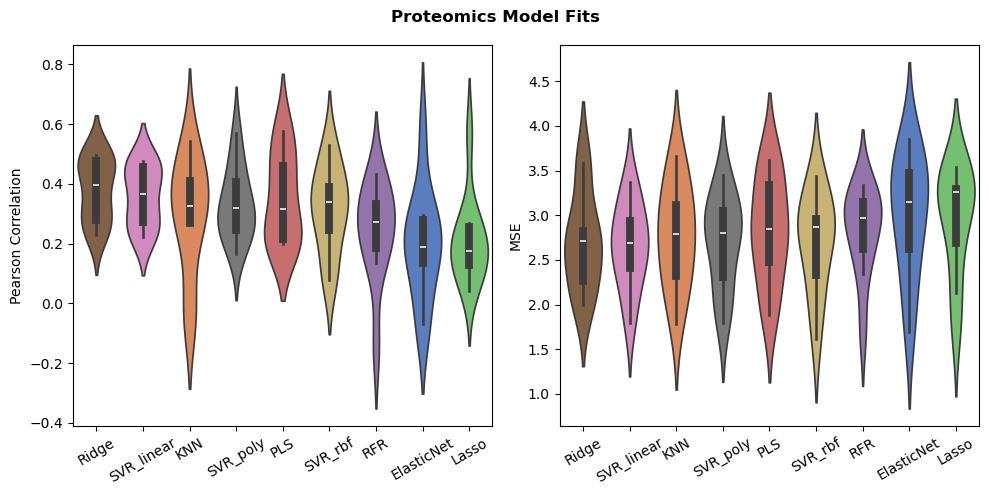

In [132]:
fig, ax = plt.subplots(ncols = 2, figsize = (10,5))

metric_types = ['corr', 'mse']
mmap = dict(zip(metric_types, ['Pearson Correlation', 'MSE']))
# order_map = dict(zip(metric_types, [corr_order, mse_order]))
order_map = dict(zip(metric_types, [model_order, model_order]))

palette = dict(zip(sorted(res.model_type.unique()), sns.color_palette("muted")))

for i, metric_type in enumerate(metric_types):
    # sort by mean of metric
    res.model_type = pd.Categorical(res.model_type, categories = order_map[metric_type], 
                               ordered = True)
    
    
    sns.violinplot(data = res, x = 'model_type', y = 'test_' + metric_type, ax = ax[i], 
                  palette = palette)#,
#                    fill = False, inner = None)
    
#     sns.boxplot(data=res, x = 'model_type', y = 'test_' + metric_type, 
#                 width=0.1, 
#                 color="black", showcaps=False, boxprops={'facecolor':'none'}, 
#                 whiskerprops={'linewidth':0.5}, ax = ax[i])
#     sns.stripplot(data=res, x = 'model_type', y = 'test_' + metric_type, 
#                   alpha=0.5, jitter=True, dodge=True, ax = ax[i], color = 'black')
    
    ax[i].set_xlabel('')
    ax[i].set_ylabel(mmap[metric_type])
    
    xlabels = [x._text for x in ax[i].get_xticklabels()]
    x_pos = dict(zip(xlabels, ax[i].get_xticks()))
    y, h = ax[i].get_ylim()[1], 0.05
    
    ax[i].set_xticklabels(xlabels, 
                          rotation=30, 
                         ha = 'center')
    
    sig_counter = 0
    for j, (comp1, comp2) in enumerate(mod_combs):#(itertools.combinations(xlabels, 2)):
        x_mid = (x_pos[comp1] + x_pos[comp2]) / 2
        
        fdr = res_stats[res_stats.comparison == (comp1, comp2)]['fdr_' + metric_type].values[0]
        cd = res_stats[res_stats.comparison == (comp1, comp2)]['cohen_d_' + metric_type].values[0]
        
        significance = "N.S."
        if fdr <= 1e-4:
            significance = "****"
        elif fdr <= 0.001:
            significance = "***"
        elif fdr <= 0.01:
            significance = "**"
        elif fdr <= 0.1:
            significance = "*"
        
        if significance != 'N.S.':
            y_pos = y+(sig_counter*0.15)
            ax[i].plot([x_pos[comp1], x_pos[comp1], x_pos[comp2], x_pos[comp2]], 
                       [y_pos, y_pos+h, y_pos+h, y_pos], 
                       lw=1.5, c='black')
            y_pos*=1.01
            ax[i].text(x_mid, y_pos + h, f"Cohen's d = {cd:.2f}, " + significance, 
                    ha='center', va='bottom', fontsize=10)
            sig_counter += 1
            

#     ax[i].grid(axis='y', linestyle='--', alpha=0.7)

# fig.suptitle('Proteomics Model Fits')
fig.suptitle('Proteomics Model Fits',
    fontweight='bold',  # Makes the text bold
)


fig.tight_layout()
plt.savefig(os.path.join(data_path, 'figures', 'all_models_proteomics.png'), 
            dpi=300, 
            bbox_inches="tight")  

For each metric (panels), violin plots are ordered by the best performing rank across folds. Each fold has the best model selected using optuna hyperparameter tuning. We observe the following: 
- there are no significant differences in any of the model performance for both correlation and MSE
- relative model performance is consistent between correlation and MSE, with SVMs performing best (with the exception of Ridge regression).

# Consensus model

Here, we simply want to assess consensus proteomics models' predictive performance, particularly relative to transcriptomics. Thus, we'll take the top three models by each metric, and see how they perform as compared to the consensus model identified for transcriptomics (in [notebook A/03]( ../A_rna_prediction/03_predict_transcriptomics.ipynb)). Between Pearson correlation and MSE, the top 3 performing models are:
- Ridge
- SVR linear
- KNN

In [133]:
X = pd.read_csv(os.path.join(data_path, 'processed',  'expr_protein.csv'), index_col = 0).values
y = pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential_protein.csv'), index_col = 0)['mean'].values.ravel()
X.shape


(248, 10969)

Let's get the consensus model for ridge:

In [134]:
model_type = 'Ridge'
print(model_type)
res_model = res[res.model_type == model_type]

n_features_best = []
alpha_best = []
for k,bp in enumerate(res_model.best_params):
    n_features = int(bp.split(', ')[0].split(': ')[1])
    alpha = float(bp.split(', ')[1].split(': ')[1][:-1])
    n_features_best.append(n_features)
    alpha_best.append(alpha)
    
    print('Fold: {}, features: {}, alpha: {:4f}'.format(k, n_features, alpha))

n_features_best = statistics.mode(n_features_best)
alpha_best = np.mean(alpha_best)
print('The consensus model has features: {}, alpha: {:.4f}'.format(n_features_best, alpha_best))

    
best_steps = [
    ("feature_reduction", ProteinFeatureSelector(n_features = n_features_best)),
    ("mean_centering", MeanCenterer()),
]
best_steps.append(("model", Ridge(
    alpha  = alpha_best,
    random_state=random_state,
#     n_jobs=n_cores
)))
best_pipeline_ridge = Pipeline(best_steps)
best_pipeline_ridge

Ridge
Fold: 0, features: 5000, alpha: 88.570674
Fold: 1, features: 5000, alpha: 95.697061
Fold: 2, features: 5000, alpha: 92.955809
Fold: 3, features: 5000, alpha: 96.554451
Fold: 4, features: 1000, alpha: 89.364140
Fold: 5, features: 5000, alpha: 75.684382
Fold: 6, features: 5000, alpha: 96.833425
Fold: 7, features: 5000, alpha: 98.699360
Fold: 8, features: 5000, alpha: 96.856177
Fold: 9, features: 5000, alpha: 79.737666
The consensus model has features: 5000, alpha: 91.0953


,steps,"[('feature_reduction', ...), ('mean_centering', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,method,'top_residuals'
,n_features,5000
,alpha,91.09531465348172
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001


In [135]:
model_type = 'SVR_linear'
print(model_type)

res_model = res[res.model_type == model_type]

n_features_best = []
C_best = []
epsilon_best = []
for k, bp in enumerate(res_model.best_params):
    n_features = int(bp.split(', ')[0].split(': ')[1])
    C = float(bp.split(', ')[1].split(': ')[1])
    epsilon = float(bp.split(', ')[2].split(': ')[1][:-1])
    
    n_features_best.append(n_features)
    C_best.append(C)
    epsilon_best.append(epsilon)    
    
    print('Fold: {}, features: {}, C: {:4f}, epsilon: {:.4f}'.format(k, n_features, C, epsilon))

n_features_best = statistics.mode(n_features_best)
C_best = np.mean(C)
epsilon_best = np.mean(epsilon_best)


print('The consensus model has features: {}, C: {:4f}, epsilon: {:.4f}'.format(n_features_best, C_best, epsilon_best))

    
best_steps = [
    ("feature_reduction", ProteinFeatureSelector(n_features = n_features_best)),
    ("mean_centering", MeanCenterer()),
]
best_steps.append(("model", SVR(
    kernel='linear',
    C=C_best,
    epsilon=epsilon_best)
))
best_pipeline_svr_linear = Pipeline(best_steps)

write_pickled_object(best_pipeline_svr_linear, 
                    os.path.join(data_path, 'processed', 'best_model_proteomics_svrlinear.pickle'))

best_pipeline_svr_linear

SVR_linear
Fold: 0, features: 5000, C: 0.025831, epsilon: 0.4607
Fold: 1, features: 5000, C: 3.359226, epsilon: 0.4309
Fold: 2, features: 5000, C: 0.000930, epsilon: 1.2812
Fold: 3, features: 5000, C: 0.029600, epsilon: 0.3080
Fold: 4, features: 1000, C: 4.516605, epsilon: 0.8071
Fold: 5, features: 5000, C: 0.382567, epsilon: 0.7610
Fold: 6, features: 5000, C: 0.016406, epsilon: 0.9732
Fold: 7, features: 5000, C: 0.017253, epsilon: 0.7158
Fold: 8, features: 5000, C: 0.000392, epsilon: 0.1473
Fold: 9, features: 5000, C: 0.498106, epsilon: 0.6145
The consensus model has features: 5000, C: 0.498106, epsilon: 0.6500


,steps,"[('feature_reduction', ...), ('mean_centering', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,method,'top_residuals'
,n_features,5000
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001


In [136]:
model_type = 'KNN'
print(model_type)

res_model = res[res.model_type == model_type]


n_features_best, knn_neighbors_best, knn_weights_best, knn_metric_best = [], [], [], []
for k, bp in enumerate(res_model.best_params):
    n_features = int(bp.split(', ')[0].split(': ')[1])
    knn_neighbors = int(bp.split(', ')[1].split(': ')[1])
    knn_weights = eval(bp.split(', ')[2].split(': ')[1])
    knn_metric = eval(bp.split(', ')[3].split(': ')[1].split('}')[0])
    
    n_features_best.append(n_features)
    knn_neighbors_best.append(knn_neighbors)
    knn_weights_best.append(knn_weights)
    knn_metric_best.append(knn_metric)
    
    print('Fold: {}, features: {}, neighbors: {}, weights: {}, metric: {}'.format(
        k, n_features, knn_neighbors, knn_weights, knn_metric))

    
n_features_best = statistics.mode(n_features_best)
knn_neighbors_best = int(np.round(np.mean(knn_neighbors_best)))
knn_weights_best = statistics.mode(knn_weights_best)
knn_metric_best = statistics.mode(knn_metric_best)

print('The consensus model has features: {}, neighbors: {}, weights: {}, metric: {}'.format(
    n_features_best, knn_neighbors_best, knn_weights_best, knn_metric_best))

best_steps = [
    ("feature_reduction", ProteinFeatureSelector(n_features = n_features_best)),
    ("mean_centering", MeanCenterer()),
]

best_steps.append(("model",  KNeighborsRegressor(
            n_neighbors=knn_neighbors_best, 
            weights=knn_weights_best,
            metric=knn_metric_best,
            n_jobs = n_cores)))

best_pipeline_knn = Pipeline(best_steps)
best_pipeline_knn

KNN
Fold: 0, features: 500, neighbors: 18, weights: distance, metric: cosine
Fold: 1, features: 5000, neighbors: 17, weights: distance, metric: cosine
Fold: 2, features: 5000, neighbors: 25, weights: uniform, metric: cosine
Fold: 3, features: 5000, neighbors: 18, weights: uniform, metric: cosine
Fold: 4, features: 5000, neighbors: 17, weights: uniform, metric: cosine
Fold: 5, features: 1000, neighbors: 20, weights: distance, metric: cosine
Fold: 6, features: 5000, neighbors: 22, weights: uniform, metric: cosine
Fold: 7, features: 5000, neighbors: 15, weights: uniform, metric: cosine
Fold: 8, features: 5000, neighbors: 15, weights: distance, metric: cosine
Fold: 9, features: 5000, neighbors: 15, weights: uniform, metric: cosine
The consensus model has features: 5000, neighbors: 18, weights: uniform, metric: cosine


,steps,"[('feature_reduction', ...), ('mean_centering', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,method,'top_residuals'
,n_features,5000
,n_neighbors,18
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2


In [137]:
best_pipelines = {'ridge': best_pipeline_ridge, 
                 'svr_linear': best_pipeline_svr_linear, 
                 'knn': best_pipeline_knn}

In [138]:
# np.random.seed(random_state)
# outer_cv = KFold(n_splits=10, shuffle=True, random_state=random_state)
# n_synthetic = 1000
# augment = False
# # res = {}

# # baseline_svr_linear = LinearRegression(n_jobs = n_cores)

# results = []
# for k, (train_idx, test_idx) in tqdm(enumerate(outer_cv.split(X, y))):
#     X_train, X_test = X[train_idx], X[test_idx]
#     y_train, y_test = y[train_idx], y[test_idx]
    
#     # augment data
#     if augment:
#         synthetic_X, synthetic_y = mixup(X_train, y_train, n_synthetic = n_synthetic, alpha = 2, 
#                                          random_state = random_state)
#         X_train = np.concatenate((X_train, synthetic_X), axis = 0)
#         y_train = np.concatenate((y_train, synthetic_y), axis = 0)
        
#     results_dict = {'fold': k}
    
#     for mod_type, best_pipeline in best_pipelines.items():
#         train_corr, test_corr, train_mse, test_mse = get_stats_best(best_pipeline, y_train, y_test, X_train, X_test)
        
#         # random y
#         y_train_rand = np.random.permutation(y_train)
#         res_y_rand = get_stats_best(best_pipeline, y_train_rand, y_test, X_train, X_test)
#         _, test_corr_y_rand, _, test_mse_y_rand = res_y_rand   
        
#         # random X
#         X_train_rand = X_train[:, np.random.permutation(X_train.shape[1])]
#         res_X_rand = get_stats_best(best_pipeline, y_train, y_test, X_train_rand, X_test)
#         _, test_corr_X_rand, _, test_mse_X_rand = res_X_rand 
        
#         mod_dict = {
#             "train_corr_" + mod_type: train_corr,
#             "test_corr_" + mod_type: test_corr,
#             'train_mse_' + mod_type: train_mse, 
#             'test_mse_' + mod_type: test_mse,
            
#             "random_y_test_corr_" + mod_type: test_corr_y_rand,
#             'random_y_test_mse_' + mod_type: test_mse_y_rand,
            
#             "random_X_test_corr_" + mod_type: test_corr_X_rand,
#             'random_X_test_mse_' + mod_type: test_mse_X_rand,
            
            
#         }
#         results_dict = {**results_dict, **mod_dict}

#     results.append(results_dict)
#     best_res_df = pd.DataFrame(results)
# best_res_df.to_csv(os.path.join(data_path, 'processed', 'proteomics_consensus_performance.csv'))
best_res_df = pd.read_csv(os.path.join(data_path, 'processed', 'proteomics_consensus_performance.csv'), 
                         index_col = 0)

In [155]:
model_types_ = ['ridge', 'svr_linear', 'knn']
metric_types_ = ['test_mse', 'test_corr']
best_res_df_ = best_res_df[
    ['fold'] + ['_'.join(i) for i in itertools.product(metric_types_, model_types_)]
]

best_res_df_ = (
    best_res_df_
        .melt(id_vars='fold', value_name='value')
        .assign(
            metric=lambda x: x.variable.str.split('_').str[:2].str.join('_'),
            model_type=lambda x: x.variable.str.split('_').str[2:].str.join('_')
        )
        .pivot(index=['fold', 'model_type'], columns='metric', values='value')
        .reset_index()[['fold', 'model_type', 'test_mse', 'test_corr']]
)

rank_order = aggregate_ranks(
    opt_res=best_res_df_.groupby('model_type', observed = True)[['test_mse', 'test_corr']].median().reset_index(), 
    feature_col = 'model_type', 
    metric_directions = {
        'test_mse': 'lower', 
        'test_corr': 'higher'
    },
    method = 'max'
)
rank_order
model_order = rank_order.model_type.tolist()


In [140]:
for model_type in best_pipelines.keys():
    print('The mean Pearson correlation for ' + model_type + ' is {:3f}'.format(best_res_df['test_corr_' + model_type].mean()))
    print('The median Pearson correlation for ' + model_type + ' is {:3f}'.format(best_res_df['test_corr_' + model_type].median()))
    print('The std Pearson correlation for ' + model_type + ' is {:3f}'.format(best_res_df['test_corr_' + model_type].std()))
    
    print('The mean MSE for ' + model_type + ' is {:3f}'.format(best_res_df['test_mse_' + model_type].mean()))
    print('The median MSE for ' + model_type + ' is {:3f}'.format(best_res_df['test_mse_' + model_type].median()))
    print('The std MSE for ' + model_type + ' is {:3f}'.format(best_res_df['test_mse_' + model_type].std()))

    print('----------')

The mean Pearson correlation for ridge is 0.412603
The median Pearson correlation for ridge is 0.446416
The std Pearson correlation for ridge is 0.192315
The mean MSE for ridge is 2.585357
The median MSE for ridge is 2.701238
The std MSE for ridge is 0.727400
----------
The mean Pearson correlation for svr_linear is 0.418415
The median Pearson correlation for svr_linear is 0.408134
The std Pearson correlation for svr_linear is 0.195217
The mean MSE for svr_linear is 2.510873
The median MSE for svr_linear is 2.545928
The std MSE for svr_linear is 0.693226
----------
The mean Pearson correlation for knn is 0.378977
The median Pearson correlation for knn is 0.379901
The std Pearson correlation for knn is 0.138420
The mean MSE for knn is 2.605813
The median MSE for knn is 2.294247
The std MSE for knn is 0.644394
----------


### Assessment 1

First, let's test whether each consensus model performs better than random:

In [141]:
viz_df = best_res_df[[col for col in best_res_df if 'test' in col or col == 'fold']]
# split by metric type
viz_df_corr = viz_df[[col for col in viz_df if 'corr' in col]]
viz_df_mse = viz_df[[col for col in viz_df if 'mse' in col]]

viz_dfs = {'Pearson Correlation': viz_df_corr, 
          'Mean Squared Error': viz_df_mse}
mmap = dict(zip(viz_dfs.keys(), ['corr', 'mse']))
model_map = dict(zip(best_pipelines.keys(), 
                    ['Ridge', 'Linear SVR', 'KNN']))

unit_map = {'h': dict(zip(viz_dfs.keys(), [0.05, 0.2])),
            'y_pos_scale_0': dict(zip(viz_dfs.keys(), [0.175, 0.525])),
           'y_pos_scale': dict(zip(viz_dfs.keys(), [1.01, 1.01])), 
           'y_max_scale': dict(zip(viz_dfs.keys(), [1.15, 1.1]))}

In [142]:
def get_stats(viz_df, stat_type, model_type, metric_type):
    res_stats = pd.DataFrame(columns = ['comparison', 'pval', 'cohen_d'])
    mod_combs = list(itertools.combinations((viz_df['Model Type'].unique()), 2))
    
    if stat_type == 'random':
        mod_combs = [mc for mc in mod_combs if '_'.join(mc).count('Randomly') == 1]
        
        if metric_type == 'Pearson Correlation':
            alternative = 'greater'
        elif metric_type == 'Mean Squared Error':
            alternative = 'less'
        
        # reorder
        shared_element = model_map[model_type]
        mod_combs = [
            (shared_element, elem[0]) if elem[1] == shared_element else (shared_element, elem[1])
            for elem in mod_combs
        ]
    elif stat_type == 'within':
        alternative = 'two-sided'
    elif stat_type == 'transcriptomics':     
        mod_combs = [mc for mc in mod_combs if '_'.join(mc).count('Transcriptomics') == 1]
        alternative = 'two-sided'
        
#         if metric_type == 'Pearson Correlation':
#             alternative = 'greater'
#         elif metric_type == 'Mean Squared Error':
#             alternative = 'less'
        
#         # reorder
#         shared_element = 'Linear SVR - Transcriptomics'
#         mod_combs = [
#             (shared_element, elem[0]) if elem[1] == shared_element else (shared_element, elem[1])
#             for elem in mod_combs
#         ]
        

    for mc in mod_combs:
        a = viz_df[viz_df['Model Type'] == mc[0]].iloc[:, 1]
        b = viz_df[viz_df['Model Type'] == mc[1]].iloc[:, 1]

        pval = stats.mannwhitneyu(a,b, alternative = alternative).pvalue
        cd = cohen_d(a,b)

        res_stats.loc[res_stats.shape[0], :] = [mc, pval, cd]

    _, fdr, _, _ = multipletests(res_stats.pval.values, method='fdr_bh')
    res_stats['fdr'] = fdr
    
    return res_stats, mod_combs

['svr_linear', 'knn', 'ridge']

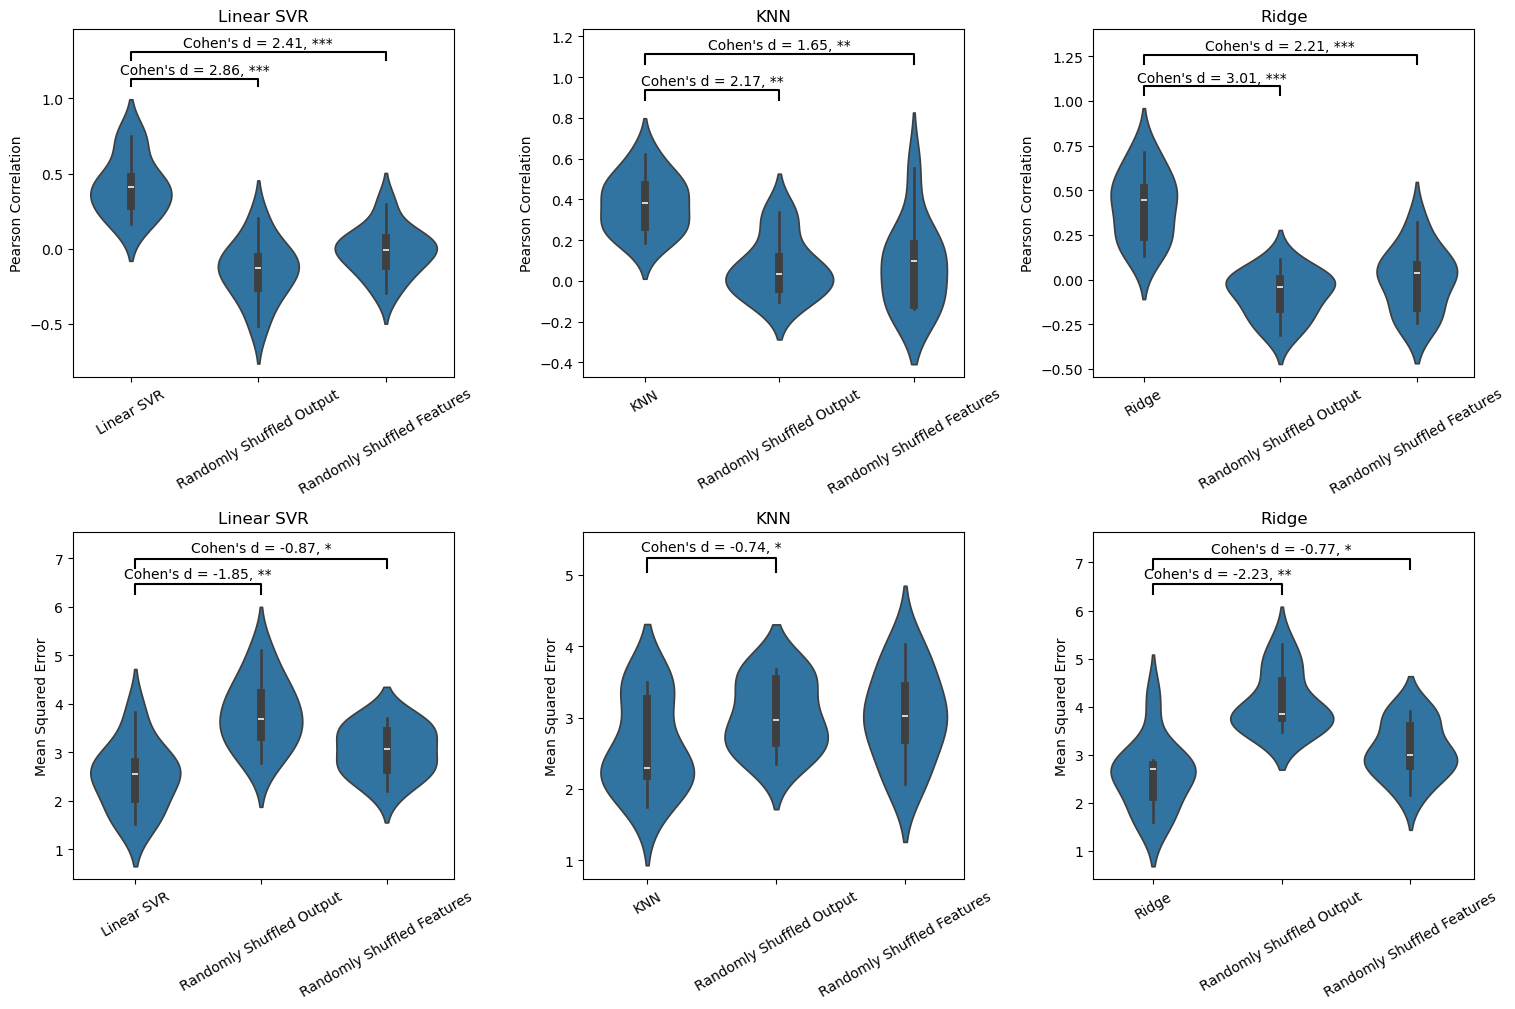

In [158]:
ncols = len(best_pipelines)
nrows = 2 # two metrics
fig, ax = plt.subplots(ncols = ncols, nrows = nrows, figsize = (ncols*5.1, nrows*5.1))

for j, model_type in enumerate(model_order):
#     break
    
    for i, (metric_type, viz_df_) in enumerate(viz_dfs.items()):
        viz_df = viz_df_[[col for col in viz_df_ if model_type in col]]
        viz_df = pd.melt(viz_df, value_name=metric_type, var_name = 'Model Type')

        # some formatting
        viz_df['Model Type'] = viz_df['Model Type'].map({'test_' +mmap[metric_type] + '_' + model_type: model_map[model_type], 
                                  'random_y_test_' +mmap[metric_type] + '_' + model_type: 'Randomly Shuffled Output', 
                                 'random_X_test_' +mmap[metric_type] + '_' + model_type: 'Randomly Shuffled Features'})
        
        # may want to do this across all comparisons simultaneously
        res_stats, mod_combs = get_stats(viz_df, stat_type = 'random', model_type = model_type, metric_type = metric_type)

        sns.violinplot(data = viz_df, x = 'Model Type', y = metric_type, ax = ax[i, j])
        ax[i, j].set_title(model_map[model_type])
        ax[i, j].set_xlabel('')
        
        xlabels = [x._text for x in ax[i, j].get_xticklabels()]
        ax[i, j].set_xticklabels(xlabels, 
                          rotation=30, 
                         ha = 'center')
        
        x_pos = dict(zip(xlabels, ax[i,j].get_xticks()))

        y_lower, y = ax[i,j].get_ylim()
        h = unit_map['h'][metric_type]
        
        # significance
        sig_counter = 0
        for k, (comp1, comp2) in enumerate(mod_combs):#(itertools.combinations(xlabels, 2)):
            x_mid = (x_pos[comp1] + x_pos[comp2]) / 2

            fdr = res_stats[res_stats.comparison == (comp1, comp2)]['fdr'].values[0]
            cd = res_stats[res_stats.comparison == (comp1, comp2)]['cohen_d'].values[0]

            significance = "N.S."
            if fdr <= 1e-4:
                significance = "****"
            elif fdr <= 0.001:
                significance = "***"
            elif fdr <= 0.01:
                significance = "**"
            elif fdr <= 0.1:
                significance = "*"

            if significance != 'N.S.':
    #             y_pos = y+(sig_counter*0.15)
                y_pos = y+(sig_counter*unit_map['y_pos_scale_0'][metric_type])
                ax[i,j].plot([x_pos[comp1], x_pos[comp1], x_pos[comp2], x_pos[comp2]], 
                        [y_pos, y_pos+h, y_pos+h, y_pos], 
                        lw=1.5, c='black')
                y_pos*=unit_map['y_pos_scale'][metric_type]
                ax[i,j].text(x_mid, y_pos + h, f"Cohen's d = {cd:.2f}, " + significance, 
                        ha='center', va='bottom', fontsize=10)
                sig_counter += 1
        if sig_counter != 0:
            ax[i,j].set_ylim(y_lower, y_pos*unit_map['y_max_scale'][metric_type])
fig.tight_layout()
plt.savefig(os.path.join(data_path, 'figures', 'random_proteomics.png'), 
            dpi=300, 
            bbox_inches="tight")  

All models perform better than random for the Pearson Correlation. However, for the MSE, only the Linear and RBF SVR performs better than both random baselines.

### Assessment 2

Next, let's test whether there is a difference in model performance across the consensus models:

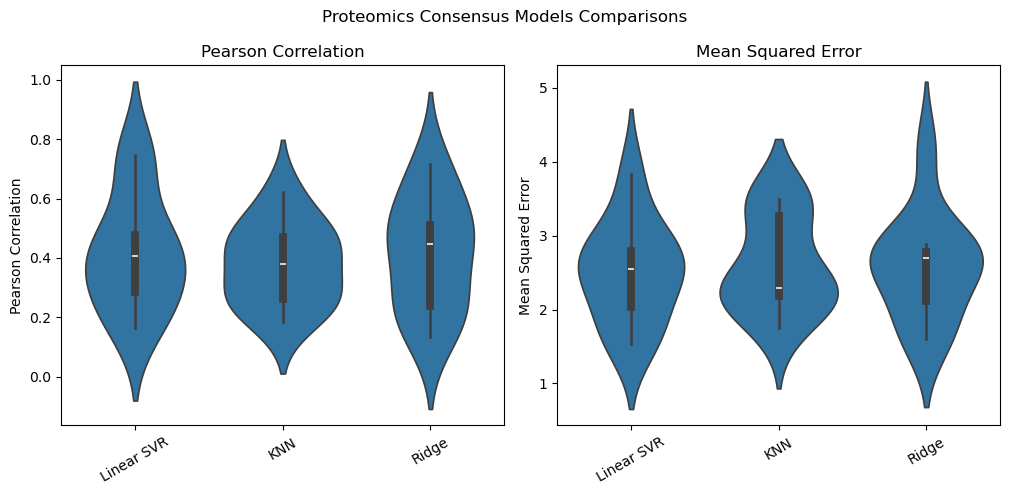

In [170]:
ncols = 2
fig, ax = plt.subplots(ncols = ncols, figsize = (ncols*5.1, 5))

am = {'Pearson Correlation': False, 'Mean Squared Error': True}

for i, (metric_type, viz_df_) in enumerate(viz_dfs.items()):
    viz_df = viz_df_[[col for col in viz_df_ if 'random' not in col]]
    viz_df = pd.melt(viz_df, value_name=metric_type, var_name = 'Model Type')

    # some formatting
    viz_df['Model Type'] = viz_df['Model Type'].map({'test_' +mmap[metric_type] + '_' + model_type: model_map[model_type] for model_type in best_pipelines.keys()})

    
    # may want to do this across all comparisons simultaneously
    res_stats, mod_combs = get_stats(viz_df, stat_type = 'within', 
                                     model_type = None, 
                                     metric_type = None)
    
#     rank_ordered_models = viz_df.groupby(['Model Type']).std()[metric].sort_values(ascending = True).index.tolist()
    viz_df['Ordered Model Type'] = pd.Categorical(viz_df['Model Type'], 
                                          categories = [model_map[m_] for m_ in model_order], 
                                          ordered = True)

    sns.violinplot(data = viz_df, x = 'Ordered Model Type', y = metric_type, ax = ax[i])
    ax[i].set_title(metric_type)
    ax[i].set_xlabel('')

    xlabels = [x._text for x in ax[i].get_xticklabels()]
    ax[i].set_xticklabels(xlabels, 
                      rotation=30, 
                     ha = 'center')

    x_pos = dict(zip(xlabels, ax[i].get_xticks()))

    y_lower, y = ax[i].get_ylim()
    h = unit_map['h'][metric_type]

    # significance
    sig_counter = 0
    for k, (comp1, comp2) in enumerate(mod_combs):#(itertools.combinations(xlabels, 2)):
        x_mid = (x_pos[comp1] + x_pos[comp2]) / 2

        fdr = res_stats[res_stats.comparison == (comp1, comp2)]['fdr'].values[0]
        cd = res_stats[res_stats.comparison == (comp1, comp2)]['cohen_d'].values[0]

        significance = "N.S."
        if fdr <= 1e-4:
            significance = "****"
        elif fdr <= 0.001:
            significance = "***"
        elif fdr <= 0.01:
            significance = "**"
        elif fdr <= 0.1:
            significance = "*"

        if significance != 'N.S.':
#             y_pos = y+(sig_counter*0.15)
            y_pos = y+(sig_counter*unit_map['y_pos_scale_0'][metric_type])
            ax[i].plot([x_pos[comp1], x_pos[comp1], x_pos[comp2], x_pos[comp2]], 
                    [y_pos, y_pos+h, y_pos+h, y_pos], 
                    lw=1.5, c='black')
            y_pos*=unit_map['y_pos_scale'][metric_type]
            ax[i].text(x_mid, y_pos + h, f"Cohen's d = {cd:.2f}, " + significance, 
                    ha='center', va='bottom', fontsize=10)
            sig_counter += 1
    if sig_counter != 0:
        ax[i].set_ylim(y_lower, y_pos*unit_map['y_max_scale'][metric_type])
        
fig.suptitle('Proteomics Consensus Models Comparisons')
fig.tight_layout()

plt.savefig(os.path.join(data_path, 'figures', 'consensus_proteomics.png'), 
            dpi=300, 
            bbox_inches="tight")  


There is no significant difference in consensus model performance by either metric.

### Assessment 3

Finally, let's test whether there is a difference in these model performances vs the consensus model identified in transcriptomics. We use the consensus linear SVR as outlined in [notebook A/03](../A_rna_prediction/03_predict_transcriptomics.ipynb). 

We use the results from the power analysis [A/05 power analysis](../A_rna_prediction/05_power_analysis_transcriptomics.ipynb), selecting the run with the number of samples equal to the number of samples available to proteomics. One caveat here is that the transcriptomic results were note calculated on the same set of folds as proteomics. However, given the bootstrapping of 100 subsets per fold, results should be consistent. 

In [145]:
X = pd.read_csv(os.path.join(data_path, 'processed',  'expr_protein.csv'), index_col = 0).values
y = pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential_protein.csv'), index_col = 0)['mean'].values.ravel()


transcriptomics_power = pd.read_csv(os.path.join(data_path, 'processed', 'power_analysis_transcriptomics_linear_svr.csv'), index_col = 0)
transcriptomics_res = transcriptomics_power[transcriptomics_power.train_sample_size == y.shape[0]]


In [146]:
transcriptomics_res.test_mse.mean()

2.081848714467299

In [147]:
transcriptomics_res.test_mse.std()

0.4047987718231994

In [148]:
transcriptomics_res.test_corr.mean()

0.42968894644096434

In [149]:
transcriptomics_res.test_corr.std()

0.11729966594197112

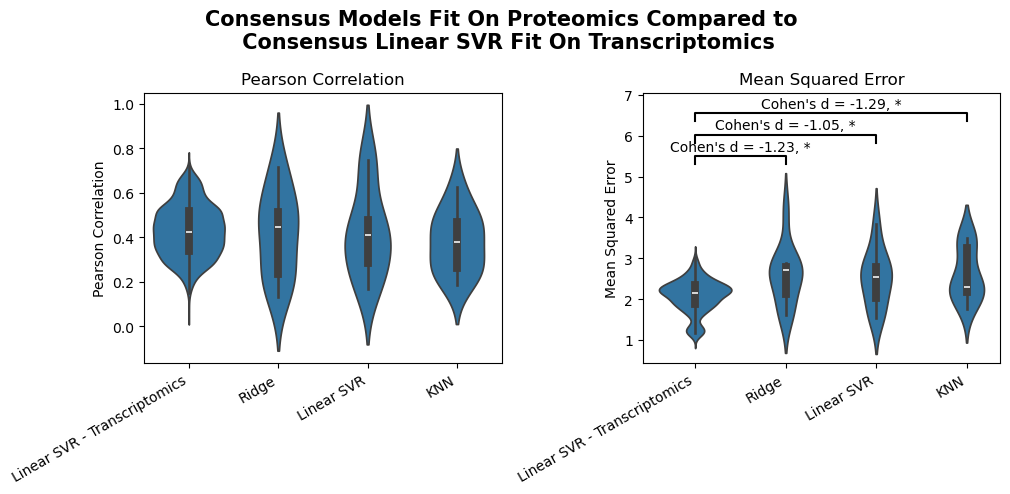

In [153]:
ncols = 2
fig, ax = plt.subplots(ncols = ncols, figsize = (ncols*5.1, 5))

res_stats_all = pd.DataFrame(columns = ['comparison', 'pval', 'cohen_d', 'fdr'])

for i, (metric_type, viz_df_) in enumerate(viz_dfs.items()):
    viz_df = viz_df_[[col for col in viz_df_ if 'random' not in col]]
    viz_df = pd.melt(viz_df, value_name=metric_type, var_name = 'Model Type')

    # some formatting
    viz_df['Model Type'] = viz_df['Model Type'].map({'test_' +mmap[metric_type] + '_' + model_type: model_map[model_type] for model_type in best_pipelines.keys()})

    viz_df_rna = pd.DataFrame(data = {'Model Type': 'Linear SVR - Transcriptomics', 
                                      metric_type: transcriptomics_res['test_' + mmap[metric_type]]}
                             ).reset_index(drop = True)
    viz_df = pd.concat([viz_df_rna, viz_df], axis = 0)
    
    res_stats, mod_combs = get_stats(viz_df, stat_type = 'transcriptomics', 
                                     model_type = None, 
                                     metric_type = None)
    res_stats_ = res_stats.copy()
    res_stats['metric'] = metric_type
    res_stats_all = pd.concat([res_stats_all, res_stats], axis = 0)
    
#     if metric_type == 'Mean Squared Error':
#         cd_print, fdr_print = res_stats[res_stats.comparison == ('Linear SVR - Transcriptomics', 'Polynomial SVR')][['cohen_d', 'fdr']].values.tolist()[0]

#         print(', '.join(['metric: ' + metric_type, 
#                   'comparison: Linear SVR - Transcriptomics^Polynomial SVR', 
#                   'cohend:{:.4f}'.format(cd_print), 
#                   'fdr:{:.4f}'.format(fdr_print)]))

    sns.violinplot(data = viz_df, x = 'Model Type', y = metric_type, ax = ax[i])
    ax[i].set_title(metric_type)
    ax[i].set_xlabel('')

    xlabels = [x._text for x in ax[i].get_xticklabels()]
    ax[i].set_xticklabels(xlabels, 
                      rotation=30, 
                     ha = 'right')

    x_pos = dict(zip(xlabels, ax[i].get_xticks()))

    y_lower, y = ax[i].get_ylim()
    h = unit_map['h'][metric_type]

    # significance
    sig_counter = 0
    for k, (comp1, comp2) in enumerate(mod_combs):#(itertools.combinations(xlabels, 2)):
        x_mid = (x_pos[comp1] + x_pos[comp2]) / 2

        fdr = res_stats[res_stats.comparison == (comp1, comp2)]['fdr'].values[0]
        cd = res_stats[res_stats.comparison == (comp1, comp2)]['cohen_d'].values[0]

        significance = "N.S."
        if fdr <= 1e-4:
            significance = "****"
        elif fdr <= 0.001:
            significance = "***"
        elif fdr <= 0.01:
            significance = "**"
        elif fdr <= 0.1:
            significance = "*"

        if significance != 'N.S.':
#             y_pos = y+(sig_counter*0.15)
            y_pos = y+(sig_counter*unit_map['y_pos_scale_0'][metric_type])
            ax[i].plot([x_pos[comp1], x_pos[comp1], x_pos[comp2], x_pos[comp2]], 
                    [y_pos, y_pos+h, y_pos+h, y_pos], 
                    lw=1.5, c='black')
            y_pos*=unit_map['y_pos_scale'][metric_type]
            ax[i].text(x_mid, y_pos + h, f"Cohen's d = {cd:.2f}, " + significance, 
                    ha='center', va='bottom', fontsize=10)
            sig_counter += 1
    if sig_counter != 0:
        ax[i].set_ylim(y_lower, y_pos*unit_map['y_max_scale'][metric_type])
        
fig.suptitle('Consensus Models Fit On Proteomics Compared to \n Consensus Linear SVR Fit On Transcriptomics', fontweight = 'bold', fontsize = 15)
fig.tight_layout()
plt.savefig(os.path.join(data_path, 'figures', 'consensus_proteomics_comparison.png'), 
            dpi=300, 
            bbox_inches="tight")  

res_stats_all.to_csv(os.path.join(data_path, 'interim', 'proteomics_consensus_comparison_statistics.csv'))

While the model performance is the same by correlation, let's check whether the consistency as measured by variance is consistent. Here, we subset transcriptomics power analysis results (1000 "samples") 1000 times to equal the size of proteomics (10 "samples" (folds)), creating a null distribution. Next, we get a p-value testing whether the variance of model performance in proteomics > that of transcriptomics (if p<0.05, alternative = 'greater', reject the null of transcriptomics var = proteomics var).

In [171]:
n_subsets = 1000
N = best_res_df.shape[0]   


bootstrap_idx = [
    np.random.choice(len(transcriptomics_res), size=N, replace=False)
    for _ in range(n_subsets)
]
null_vars = {}  
for metric_type in metric_types_:
    null_metric = transcriptomics_res[metric_type].values 
    vars_for_metric = []
    for idx in bootstrap_idx:
        vars_for_metric.append(null_metric[idx].var(ddof=1))

    null_vars[metric_type] = np.array(vars_for_metric)

var_stats = {'model_type': [], 'metric_type': [], 'pval': []}
for model_type, metric_type in itertools.product(model_types_, metric_types_):

    actual_var = best_res_df[f"{metric_type}_{model_type}"].var(ddof=1)

    # one-sided p-value: actual_var > null
    pval = (null_vars[metric_type] >= actual_var).mean()

    var_stats['model_type'].append(model_type)
    var_stats['metric_type'].append(metric_type)
    var_stats['pval'].append(pval)

var_stats = pd.DataFrame(var_stats)


var_stats['fdr'] = np.nan

for metric_type in metric_types_:
    mask = var_stats['metric_type'] == metric_type
    pvals = var_stats.loc[mask, 'pval'].values
    _, fdr_corr, _, _ = multipletests(pvals, method='fdr_bh')

    var_stats.loc[mask, 'fdr'] = fdr_corr

var_stats = var_stats.sort_values(by = ['metric_type', 'model_type']).reset_index(drop = True)
var_stats

,model_type,metric_type,pval,fdr
0,knn,test_corr,0.176,0.1760
1,ridge,test_corr,0.002,0.0030
2,svr_linear,test_corr,0.001,0.0030
3,knn,test_mse,0.005,0.0050
4,ridge,test_mse,0.000,0.0000
5,svr_linear,test_mse,0.001,0.0015


Overall, there is no difference in predictive performance as measured by Pearson correlation between the consensus transcriptomics model and the various consensus proteomics models. This is particularly interesting given the proteomics only require 5000 models, in contrast to all features in the transcriptomics model.

Furthermore, all proteomics models perform worse by MSE than the consensus linear model. These results indicate that prediction on transcriptomics alone may have higher utility than on proteomics alone. 

However, the variance of the transcriptomics model is significantly lower than that of ridge and linear svr for Pearson, and lower than that of all consensus models for MSE, further supporting that transcriptomics model has better "performance".

*Key points*
- Within proteomics, linear SVR has the highest rank
- Within proteomics, KNN doesn't always outperform random baselines
- Between transcriptomics and proteomics, transcriptomics performs better by MSE, and proteomics does not perform better by Pearson
- Between transcriptomics and proteomics, transcriptomics has lower variance for most models by Pearson correlations and all models by MSE


In [42]:
fns = [os.path.join(data_path, 'figures', 'consensus_proteomics_comparison.png'), 
       os.path.join(data_path, 'figures', 'random_proteomics.png'), 
       os.path.join(data_path, 'processed', 'proteomics_consensus_performance.csv'), 
       os.path.join(data_path, 'figures', 'all_models_proteomics.png')]

for fn in fns:
    cmd = 'scp hmbaghda@orcd-login001.mit.edu:' + fn
    cmd += ' Downloads/figures/.'
    print(cmd)

scp hmbaghda@satori-login-002.mit.edu:/nobackup/users/hmbaghda/metastatic_potential/figures/consensus_proteomics_comparison.png Downloads/figures/.
scp hmbaghda@satori-login-002.mit.edu:/nobackup/users/hmbaghda/metastatic_potential/figures/random_proteomics.png Downloads/figures/.
scp hmbaghda@satori-login-002.mit.edu:/nobackup/users/hmbaghda/metastatic_potential/processed/proteomics_consensus_performance.csv Downloads/figures/.
scp hmbaghda@satori-login-002.mit.edu:/nobackup/users/hmbaghda/metastatic_potential/figures/all_models_proteomics.png Downloads/figures/.
